In [2]:
import pandas as pd
import pyreadr
seed = 42

## Load the dataframe and find a binary categorical variable

In [3]:
df = pyreadr.read_r('./data/ncds_sample.RData')['ncds_sample']
df['malaise_group'].value_counts()

malaise_group
0.0    364
1.0     58
Name: count, dtype: int64

### Clean and split the data

In [4]:
from sklearn.model_selection import train_test_split
# take the relevant columns
y = df['malaise_group']
x = df.iloc[:, 1:51]
# drop na values
df = pd.concat([y, x], axis=1).dropna()

# split off a test set
train_df, test_df = train_test_split(df,test_size=0.2, random_state=seed)
train_y = train_df.pop('malaise_group')
test_y = test_df.pop('malaise_group')
print(train_df.shape, test_df.shape)

# standardize all predictors AFTER the split
def z_score_standardization(series):
    return (series-series.mean()/series.std())
for col in x.columns:
    train_df.loc[:,col] = z_score_standardization(train_df[col])
    test_df.loc[:,col] = z_score_standardization(test_df[col])

(306, 50) (77, 50)


## Logistic Regression using Lasso and Ridge

In [5]:
from sklearn.linear_model import LogisticRegression

# Prepare a dictionary for results of all models
results_dict = {'coefficients':['intercept']}
for column in test_df.columns:
    results_dict['coefficients'].append(column)

In [8]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

regressor = LogisticRegression(random_state=seed, penalty='l1', solver='liblinear', C=0.5)
kfold = KFold(n_splits=5, random_state=seed, shuffle=True)
results = cross_val_score(regressor, train_df, train_y, cv=kfold, scoring='f1')

print(results)

[0.44444444 0.57142857 0.18181818 0.15384615 0.47058824]


## Look at Adjusting the Lambda Value
Note: In sklearn, the argument C represents the inverse of the regularization strength.
Smaller values of C represent stronger regularization

In [47]:
from sklearn.metrics import f1_score, classification_report
import numpy as np
import seaborn as sns

k=10

# Function to get results
def get_results(penalty, c):
    regressor = LogisticRegression(random_state=seed, penalty=penalty, solver='liblinear', C=c)
    clf = regressor.fit(train_df, train_y)
    preds = clf.predict(test_df)
    score = f1_score(test_y, preds)
    num_variables = (clf.coef_ != 0).sum()
    coefficients = clf.coef_.flatten()
    return num_variables, score, coefficients

# For LASSO
graph_dict = {'lambda':[], 'num_variables':[], 'f1_score':[]}
coef_dict = {}
for i in np.arange(0.001, 1, 0.001): # iterate through possible values for C
    num_variables, score, coefficients = get_results('l1', i) # 'l1' is for Lasso
    coef_dict[i] = list(coefficients)
    graph_dict['lambda'].append(i)
    graph_dict['num_variables'].append(num_variables)
    graph_dict['f1_score'].append(score)
lasso_coefficients = pd.DataFrame(coef_dict)
lasso_effectiveness = pd.DataFrame(graph_dict)

# For Ridge
graph_dict = {'lambda':[], 'num_variables':[], 'f1_score':[]}
coef_dict = {}
for i in np.arange(0.001, 0.5, 0.001): # iterate through possible values for C
    num_variables, score, coefficients = get_results('l2', i) # 'l2' is for Ridge
    coef_dict[i] = list(coefficients)
    graph_dict['lambda'].append(i)
    graph_dict['num_variables'].append(num_variables)
    graph_dict['f1_score'].append(score)
ridge_coefficients = pd.DataFrame(coef_dict)
ridge_effectiveness = pd.DataFrame(graph_dict)

### Look at effect of C on coefficient strength

Text(0.5, 0, '1/lambda')

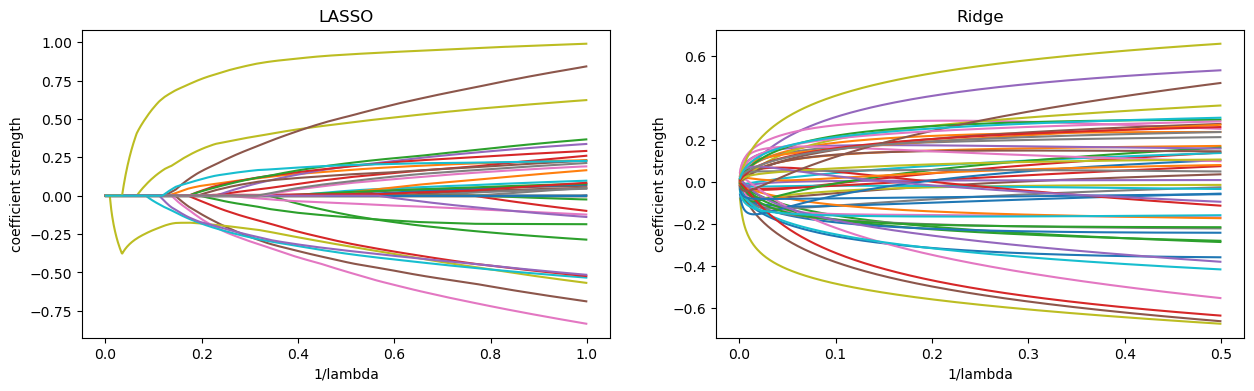

In [51]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,4))
lasso_coefficients.T.plot(legend=False, ax=ax1)
ax1.set_title('LASSO')
ax1.set_xlabel('1/lambda')
ax1.set_ylabel('coefficient strength')
ridge_coefficients.T.plot(legend=False, ax=ax2)
ax2.set_title('Ridge')
ax2.set_ylabel('coefficient strength')
ax2.set_xlabel('1/lambda')

### Look at the affect of C on F1 and number of variables retained

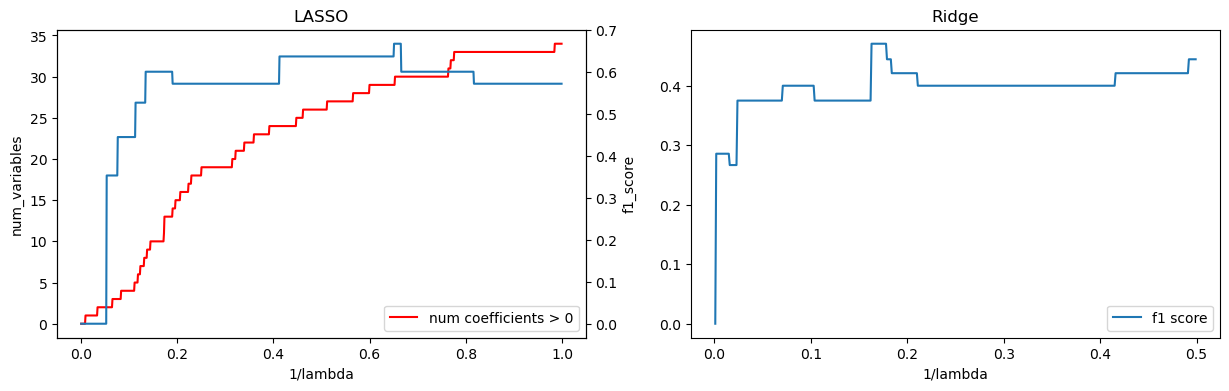

In [60]:
import matplotlib.pyplot as plt
fig, (ax1, ax3) = plt.subplots(1,2, figsize=(15,4))
sns.lineplot(lasso_effectiveness, x='lambda', y='num_variables', ax=ax1, color='red')
ax2 = ax1.twinx()
ax1.set_title('LASSO')
ax1.set_xlabel('1/lambda')
sns.lineplot(lasso_effectiveness, x='lambda', y='f1_score', ax=ax2)
sns.lineplot(ridge_effectiveness, x='lambda', y='f1_score', ax=ax3)
ax3.set_title('Ridge')
ax3.set_ylabel(None)
ax3.set_xlabel('1/lambda')
ax1.legend(labels=['num coefficients > 0'], loc='lower right')
ax3.legend(labels=['f1 score'], loc='lower right')

In [24]:
from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV(cv=5, 
                           random_state=seed, 
                           Cs=5, 
                           penalty='l1', 
                           solver='saga', 
                           max_iter=5000)
clf.fit(train_df, train_y)
clf.score(test_df, test_y)

0.8961038961038961

### Ridge
I am using cross-validation
ScikitLearn automatically searches for an optimal lambda.
From the documentation:
"Each of the values in Cs describes the inverse of regularization strength. If Cs is as an int, then a grid of Cs values are chosen in a logarithmic scale between 1e-4 and 1e4. Like in support vector machines, smaller values specify stronger regularization."

In [35]:
from sklearn.linear_model import LogisticRegressionCV

ridge = LogisticRegressionCV(cv=10, 
                           random_state=seed, 
                           Cs=10, 
                           penalty='l2', 
                           solver='saga', 
                           max_iter=5000)

ridge_clf = ridge.fit(train_df, train_y)
results = [float(ridge_clf.intercept_.flatten()[0])]
for i in ridge_clf.coef_.flatten():
    results.append(i)
ridge_preds = ridge_clf.predict(test_df)
print(classification_report(ridge_preds, test_y))
results_dict['ridge'] = results

              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94        70
         1.0       0.45      0.71      0.56         7

    accuracy                           0.90        77
   macro avg       0.71      0.81      0.75        77
weighted avg       0.92      0.90      0.91        77



### Lasso

In [36]:
from sklearn.linear_model import LogisticRegressionCV
lasso = LogisticRegressionCV(cv=10, 
                           random_state=seed, 
                           Cs=10, 
                           penalty='l1', 
                           solver='saga', 
                           max_iter=5000)
lasso_clf = lasso.fit(train_df, train_y)
results = [float(lasso_clf.intercept_.flatten())]
for i in lasso_clf.coef_.flatten():
    results.append(i)
results_dict['lasso'] = results
lasso_preds = lasso_clf.predict(test_df)
print(classification_report(test_y, lasso_preds))

              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94        66
         1.0       0.64      0.64      0.64        11

    accuracy                           0.90        77
   macro avg       0.79      0.79      0.79        77
weighted avg       0.90      0.90      0.90        77



C:\Users\morriwg1\AppData\Local\Temp\ipykernel_29712\1970475886.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  results = [float(lasso_clf.intercept_.flatten())]


### Normal Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegressionCV
logistic = LogisticRegressionCV(cv=5, 
                           random_state=seed,
                           Cs = [1], # Manually setting C to be 1, which is identical to normal log-reg.
                           penalty='l2', 
                           solver='saga', 
                           max_iter=5000)

normal_clf = logistic.fit(train_df, train_y)
results = [float(normal_clf.intercept_.flatten())]
for i in normal_clf.coef_.flatten():
    results.append(i)
results_dict['normal'] = results

normal_preds = normal_clf.predict(test_df)
print(classification_report(test_y, normal_preds))

              precision    recall  f1-score   support

         0.0       0.93      0.94      0.93        66
         1.0       0.60      0.55      0.57        11

    accuracy                           0.88        77
   macro avg       0.76      0.74      0.75        77
weighted avg       0.88      0.88      0.88        77



C:\Users\morriwg1\AppData\Local\Temp\ipykernel_29712\3582099759.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  results = [float(normal_clf.intercept_.flatten())]


## Results

In [46]:
results_df = pd.DataFrame(results_dict)
print('Num Variable:', len(results_df['coefficients']))
print('Num Variables (LASSO):', results_df[results_df['lasso']!=0].lasso.count())

print('Normal F1:', round(f1_score(normal_preds, test_y), 2))
print('Normal optimal C:', logistic.C_[0])
print('Lasso F1:', round(f1_score(lasso_preds, test_y), 2))
print('Lasso optimal C:', lasso.C_[0])
print('Ridge F1:', round(f1_score(ridge_preds, test_y), 2))
print('Ridge optimal C:', ridge.C_[0])

Num Variable: 51
Num Variables (LASSO): 20
Normal F1: 0.57
Normal optimal C: 1
Lasso F1: 0.64
Lasso optimal C: 0.3593813663804626
Ridge F1: 0.56
Ridge optimal C: 0.046415888336127774


In [39]:
results_df

,coefficients,ridge,lasso,normal
0,intercept,-3.470514,-4.387051,-6.419613
1,I am the life of the party,-0.064404,0.000000,0.007945
2,I feel little concern for others,0.106050,0.145691,0.217330
3,I am always prepared,-0.098427,-0.042690,-0.445711
4,I get stressed out easily,0.118009,0.107903,0.451192
5,I have a rich vocabulary,0.109063,0.103713,0.453882
6,I don't talk a lot,0.014628,0.000000,0.133504
7,I am interested in people,-0.087828,0.000000,-0.278929
8,I leave my belongings around,0.002957,0.000000,0.123468
9,I am relaxed most of the time,-0.011294,0.000000,-0.047092
